In [1]:
import numpy as np
import pandas as pd
import seaborn as sb

In [2]:
dataset = pd.read_csv("/home/naman/Desktop/car.csv",delimiter=',',verbose = True)

Tokenization took: 0.62 ms
Type conversion took: 1.83 ms
Parser memory cleanup took: 0.01 ms


This dataset is Car's dataset. It encodes various features of cars into columnar values. The columns include  buying, maint, doors, persons, lug_boot, safety<br>
The output classes are unacc,acc,good,vgood

We will build a tree and visualize it! Then we will classify a test sample to see how it performs

In [3]:
data = dataset.dropna()   #dropping rows with missing values
data.head()

,buying,maint,doors,persons,lug_boot,safety,class
0,vhigh,vhigh,2,2,small,low,unacc
1,vhigh,vhigh,2,2,small,med,unacc
2,vhigh,vhigh,2,2,small,high,unacc
3,vhigh,vhigh,2,2,med,low,unacc
4,vhigh,vhigh,2,2,med,med,unacc


In [4]:
#splitting into training and test data
train = data.sample(frac=0.8,random_state=200)
test = data.drop(train.index)

# Taking the outputs into array named label
label = data['class']
train = train.drop("class",axis = 1)


Let's explore the data a bit.
Let us plot each feature

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
def makebarplot(data,cols):
    addtn = len(cols)%3
    if addtn > 0:
        addtn = 1
    sub1 = len(cols)//3 + addtn 
    sub2 = 3
    fig = plt.figure()
    for index,i in enumerate(cols):
        item = data[i].unique()
        X = np.array(range(len(item)))
        Y = [data.groupby(i)[i].count()[j] for j in item]
        print Y
        ax = fig.add_subplot(sub1,sub2,index+1)
        ax.bar(X,Y,align = 'center')
        plt.setp(ax,xticks=X, xticklabels=item,xlabel = i)

<IPython.core.display.Javascript object>


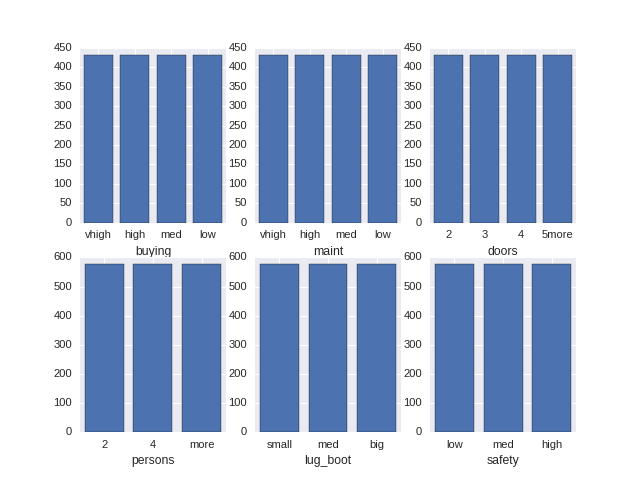

[432, 432, 432, 432]
[432, 432, 432, 432]
[432, 432, 432, 432]
[576, 576, 576]
[576, 576, 576]
[576, 576, 576]


In [6]:
makebarplot(data,[ "buying", "maint", "doors", "persons", "lug_boot", "safety"])
#we see that almost all classes have a similar count!

In [7]:
def makestackedplot(data,cols,target,noofcolsplot = 3):
    addtn = len(cols)%3
    if addtn > 0:
        addtn = 1
    sub1 = len(cols)//3 + addtn 
    sub2 = 3
    fig = plt.figure()

    for index,nameofcol in enumerate(cols):
        item = data[nameofcol].unique()
        X = np.array(range(len(item)))
        classes = data[target].unique()
        Y = np.zeros((classes.shape[0],item.shape[0]))
        ax = fig.add_subplot(sub1,sub2,index+1)
        
        for ind,targetlabel in enumerate(classes):
            Y[ind] = [(data[(data[nameofcol] == value) & (data[target] == targetlabel)]).shape[0] for value in item]
        
        ax.bar(X,Y[0,:],color = 'r',align = 'center')
        ax.bar(X,Y[1,:],color = 'b',bottom = Y[0,:],align = 'center')
        ax.bar(X,Y[2,:],color = 'g',bottom = [i+j for i,j in zip(Y[1,:],Y[0,:])],align = 'center')
        ax.bar(X,Y[3,:],color = 'c',bottom = [i+j+k for i,j,k in zip(Y[1,:],Y[0,:],Y[2,:])],align = 'center')
        
        plt.setp(ax,xticks=X, xticklabels=item,xlabel = nameofcol)
    plt.legend(data[target].unique(),bbox_to_anchor=(1.5, 1.2))

<IPython.core.display.Javascript object>


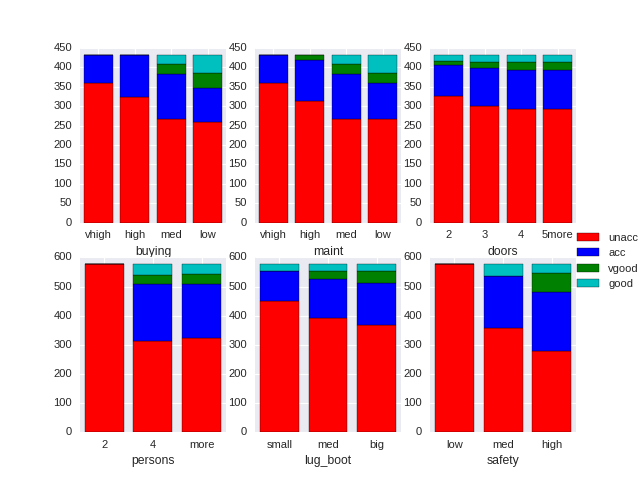

In [8]:
makestackedplot(data,["buying", "maint", "doors", "persons", "lug_boot", "safety"],"class")

ID3 is a tree based algorithm <br>
It is as follows
1. Calculate the Entropy
2. for each ppossible feature split in dataset, calculate the gain
3. The feature giving maximum gain is chosen for split.
4. for each child node created
> 4.1. If only one class is present. Stop the algorithm for this node <br>
> 4.2. else if no feature to split. Majority vote classifier,<br>
> 4.3. else goto step 2 

ID3 has a tendency of overfitting. We should usually limit the depth of the tree else it is bound to overfit!

In [9]:
#We will make a tree creation algorithm. Trees contain node and leaves
class Node():
    def __init__(self,Parent,data):
        self.Parent = Parent
        self.data = data       #data at this node
        self.children = None   #children nodes
        self.splitat = None    #Split for feature
        self.isleaf = None     #flag for leaf
        self.label = None      #ifLeaf what is the decision
        self.values = None     #The edge names 
        
    def __str__(self):
        return str(self.splitat)
    
#node with parent = None will be the root
#node with isleaf = True is the leaf
#all other nodes 

root = Node(None,data)



Entropy$$H(X) = -\sum_{i=1}^n p(x_i)*log_2p(x_i)$$
Information Gain
$$IG(X,T) = H(X) -\sum_{i}\frac {|T_i|}{|X|}H(T_i)$$

In [10]:
def entropy(datacol,classes,verbose = False):
    #calculate probabilities of each category
    noofrows = datacol.shape[0]
    probs = np.zeros(classes.shape[0])
    logprobs = np.zeros(classes.shape[0])
    for indexent,item in enumerate(classes):
        probs[indexent] = (datacol == item).sum()/float(noofrows)                
        if probs[indexent] == 0:
            logprobs[indexent] = 0
        else:
            logprobs[indexent] = -np.log2(probs[indexent])
    if verbose:
        print "\n entropy of split info :\n probs = ",probs," \n logprob = ",logprobs, 
    
    #calculate entropy
    entrop = np.dot(probs,logprobs)
    
    if verbose:
        print "\nis ",entrop,"\n\n"
    
    return entrop

In [11]:
#make a function splitnode(node)
#It will take input node and find the most appropriate feature to split on. The it'll create children node.
#Each child contains subset of parent data
def splitnode(node,target,verbose = False):
    data = node.data
    colms = data.columns
    classes = data[target].unique()

    entropyofdata = entropy(data[target],classes,verbose)
    gains = np.zeros(colms.shape[0] - 1)                    #to store gains after each column split

    #To find the best column, we calculate entropy when the splits will be made for each feature
    for index,feature in enumerate(colms[:-1]):
        #find unique categories
        categories = data[feature].unique()

        #if a category "color" has 3 values Red,Green,Blue we calculate entropy of subset data 
        for value in categories:
            subsetdata = data[data[feature] == value]
            if verbose:
                print "calling entropy on ",feature,":", value
            entrop= entropy(subsetdata[target],classes,verbose)
            contri = subsetdata.shape[0]/float(data.shape[0])
            gains[index] -= entrop*contri
        gains[index] += entropyofdata
    if verbose:
        print "\n gain for",colms[:-1],"are: ",gains 

    winner = np.argmax(gains)
    to_be_split_on =  colms[winner]
    node.children = list()
    categories = data[to_be_split_on].unique()
    for item in categories:
        temp = data[data[to_be_split_on] == item]
        temp = temp.drop(to_be_split_on,axis = 1)
        tempnode = Node(node,temp)
        tempnode.Parent = node
        node.children.append(tempnode)
    node.splitat = to_be_split_on
    node.value = list(categories)

In [12]:
#iterative tree creation using BFS
#here we will use a sum from techmax pg 8-32 classifying shape using trees. 
#The tree for Car dataset produces a very huge graph with approximately 4^3 nodes
datass = pd.read_csv("/home/naman/Desktop/find.csv",delimiter=',',verbose = True)
root.data = datass
target = "shape"
verbose = False
splitnode(root,target,verbose)
childrenQ = list(root.children)
child = childrenQ[0]
del childrenQ[0]
while child:
    data = child.data
    if data[target].unique().shape[0] == 1 :
        child.isleaf = True
        child.label = data[target].unique()[0]
        print "majority"
    elif data.columns.shape[0] == 1:
        child.isleaf = True
        child.label = data[target].mode()[0]
        print "did vote "
    else:
        splitnode(child,target,verbose)
        childrenQ = childrenQ + list(child.children)
        print "did split for: ",child
    if childrenQ == []:
        child = None
    else:
        child = childrenQ[0]
        del childrenQ[0]
        

Tokenization took: 0.15 ms
Type conversion took: 0.54 ms
Parser memory cleanup took: 0.01 ms
did split for:  outline
majority
did split for:  dot
majority
majority
majority
majority


In [13]:
#testing a new data point [color,outline,dot]
indices = {"color": 0,"outline":1,"dot":2}

datapoint = ["green","dashed","yes"]

def predict(datapoint,node):
    if node.isleaf:
        return "It is a " +node.label
    else:
        index = indices[node.splitat]    #decide which feature this node splits on
        print "checking",node.splitat
        value_search = datapoint[index]  #decide which value of the feature is in input
        which_child = node.value.index(value_search)  #which node to go next 
        newnode = node.children[which_child]
        return predict(datapoint,newnode)  #recursive call

In [14]:
predict(datapoint,root)


checking color
checking outline


'It is a triangle'

In [15]:
#TODO
##Find a visualization tool for self built tree